In [1]:
import math
from simtk import unit
from openmmtools import testsystems, states, mcmc, multistate
import os
import tempfile
import pickle
from perses.annihilation.lambda_protocol import RelativeAlchemicalState
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
from matplotlib import pyplot as plt

DEBUG:matplotlib:$HOME=/home/zhangi
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.1
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [4]:
htf = pickle.load(open("/data/chodera/zhangi/perses_benchmark/neq/7/6/6_vacuum.pickle", "rb" ))

### NEW cache

In [5]:
i = 6
aa = 'ala'
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/7/{i}/"

In [6]:
new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)

In [8]:
old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)

In [7]:
new_top.n_atoms

22

In [9]:
old_top.n_atoms

26

In [51]:
# pos = []
# for i in range(5000):
#     state = reporter.read_sampler_states(i)[11]
#     new_pos = htf.new_positions(state.positions)
#     pos.append(new_pos.value_in_unit_system(unit.md_unit_system))

In [10]:
# From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
from perses.analysis.utils import open_netcdf
nc = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}.nc"))
nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_checkpoint.nc"))
checkpoint_interval = nc_checkpoint.CheckpointInterval
all_positions = nc_checkpoint.variables['positions']
n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)

In [11]:
n_atoms

28

In [12]:
from tqdm import tqdm
index = 0 # of replica
all_pos = np.zeros(shape=(n_iter, 22, 3))
all_pos_old = np.zeros(shape=(n_iter, 26, 3))
all_pos_hybrid = np.zeros(shape=(n_iter, 28, 3))
for iteration in tqdm(range(n_iter)):
    replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
    pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
    all_pos[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
    all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions
    all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)

100%|██████████| 5001/5001 [00:48<00:00, 103.90it/s]


In [13]:
np.array(all_pos).shape

(5001, 22, 3)

In [14]:
traj = md.Trajectory(np.array(all_pos), new_top)

In [45]:
for atom in traj.topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-C 11
ALA2-O 12
ALA2-HB1 13
ALA2-HB2 14
ALA2-HB3 15
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [12]:
traj.save(os.path.join(out_dir, f"{aa}_traj.pdb"))

In [46]:
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 10, 15]])) # mdtraj atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[10, 9, 11, 16]])) # pymol atom ID
# dihedrals = md.compute_dihedrals(traj, np.array([[14, 8, 11, 12]])) # pymol atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 11, 12]])) # indices used in analyze_correlation_times
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # SER -- from dominic (using mdtraj indices)
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[18, 10, 8, 6]]))) # THR 
dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # from dominic (using mdtraj indices)

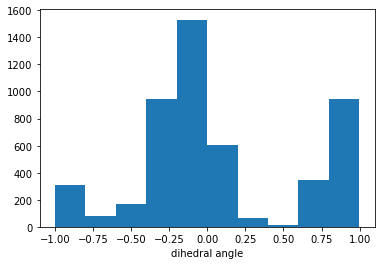

In [47]:
plt.hist(dihedrals)
plt.xlabel("dihedral angle")
plt.show()

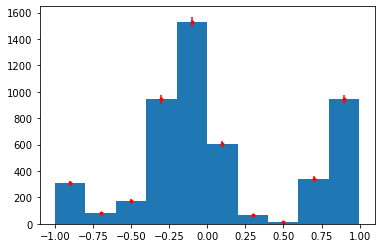

In [48]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

In [32]:
from perses.dispersed import feptasks
t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

In [33]:
t0

949

In [34]:
uncorrelated_indices

[949,
 954,
 958,
 963,
 968,
 972,
 977,
 982,
 986,
 991,
 996,
 1000,
 1005,
 1010,
 1014,
 1019,
 1024,
 1028,
 1033,
 1038,
 1042,
 1047,
 1052,
 1056,
 1061,
 1066,
 1070,
 1075,
 1080,
 1084,
 1089,
 1094,
 1098,
 1103,
 1108,
 1112,
 1117,
 1122,
 1126,
 1131,
 1136,
 1140,
 1145,
 1150,
 1154,
 1159,
 1164,
 1168,
 1173,
 1178,
 1182,
 1187,
 1192,
 1196,
 1201,
 1206,
 1210,
 1215,
 1220,
 1224,
 1229,
 1234,
 1238,
 1243,
 1248,
 1252,
 1257,
 1262,
 1266,
 1271,
 1276,
 1280,
 1285,
 1290,
 1294,
 1299,
 1304,
 1308,
 1313,
 1318,
 1322,
 1327,
 1332,
 1336,
 1341,
 1346,
 1350,
 1355,
 1360,
 1364,
 1369,
 1373,
 1378,
 1383,
 1387,
 1392,
 1397,
 1401,
 1406,
 1411,
 1415,
 1420,
 1425,
 1429,
 1434,
 1439,
 1443,
 1448,
 1453,
 1457,
 1462,
 1467,
 1471,
 1476,
 1481,
 1485,
 1490,
 1495,
 1499,
 1504,
 1509,
 1513,
 1518,
 1523,
 1527,
 1532,
 1537,
 1541,
 1546,
 1551,
 1555,
 1560,
 1565,
 1569,
 1574,
 1579,
 1583,
 1588,
 1593,
 1597,
 1602,
 1607,
 1611,
 1616,
 16

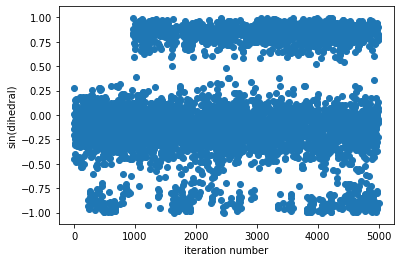

In [35]:
plt.scatter(range(n_iter), dihedrals)
plt.ylabel("sin(dihedral)")
plt.xlabel("iteration number")
plt.savefig(os.path.join(out_dir, f"{aa}_mixing.png"))
plt.show()

In [36]:
dihedrals[uncorrelated_indices].shape

(869, 1)

In [37]:
neff_max

868.8467

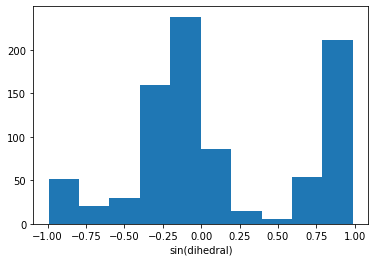

In [38]:
plt.hist(dihedrals[uncorrelated_indices])
plt.xlabel("sin(dihedral)")
plt.show()

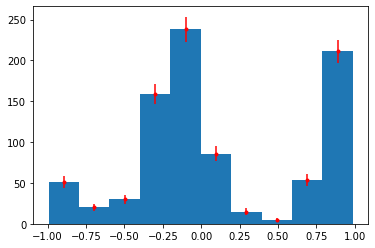

In [39]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

In [22]:
snapshots = np.random.choice(uncorrelated_indices, size=200, replace=False)

In [23]:
snapshots.shape

(200,)

In [24]:
# Save snapshot indices and positions arrays
with open(os.path.join(out_dir, f"{aa}_indices.npy"), 'wb') as f:
    np.save(f, snapshots)
with open(os.path.join(out_dir, f"{aa}_pos_hybrid.npy"), 'wb') as f:
    np.save(f, all_pos_hybrid)
### NOTE: this should be old positions, not hybrid??

In [15]:
# with open(os.path.join(out_dir, f"ser_pos_hybrid.npy"), 'rb') as f:
#     ser_pos_hybrid = np.load(f)

In [179]:
# with open(os.path.join(out_dir, f"ala_pos_hybrid.npy"), 'rb') as f:
#     ala_pos_hybrid = np.load(f)

Plot dihedral distribution of old atoms

In [49]:
traj = md.Trajectory(np.array(all_pos_old), old_top)

In [50]:
for atom in traj.topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
THR2-N 6
THR2-H 7
THR2-CA 8
THR2-HA 9
THR2-CB 10
THR2-C 11
THR2-O 12
THR2-HB 13
THR2-CG2 14
THR2-HG21 15
THR2-HG22 16
THR2-HG23 17
THR2-OG1 18
THR2-HG1 19
NME3-N 20
NME3-H 21
NME3-C 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [42]:
traj.save(os.path.join(out_dir, f"{aa}_traj.pdb"))

In [51]:
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 10, 15]])) # mdtraj atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[10, 9, 11, 16]])) # pymol atom ID
# dihedrals = md.compute_dihedrals(traj, np.array([[14, 8, 11, 12]])) # pymol atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 11, 12]])) # indices used in analyze_correlation_times
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # SER -- from dominic (using mdtraj indices)
dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[18, 10, 8, 6]]))) # THR 
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # from dominic (using mdtraj indices)

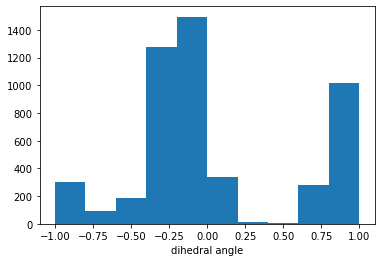

In [52]:
plt.hist(dihedrals)
plt.xlabel("dihedral angle")
plt.show()

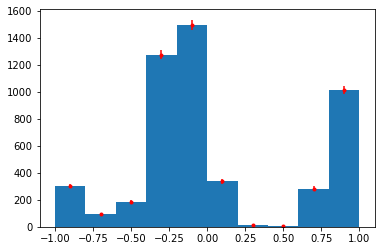

In [53]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

In [46]:
from perses.dispersed import feptasks
t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

In [47]:
t0

947

In [48]:
uncorrelated_indices

[947,
 952,
 957,
 962,
 967,
 971,
 976,
 981,
 986,
 991,
 996,
 1001,
 1006,
 1010,
 1015,
 1020,
 1025,
 1030,
 1035,
 1040,
 1045,
 1049,
 1054,
 1059,
 1064,
 1069,
 1074,
 1079,
 1084,
 1088,
 1093,
 1098,
 1103,
 1108,
 1113,
 1118,
 1123,
 1127,
 1132,
 1137,
 1142,
 1147,
 1152,
 1157,
 1162,
 1167,
 1171,
 1176,
 1181,
 1186,
 1191,
 1196,
 1201,
 1206,
 1210,
 1215,
 1220,
 1225,
 1230,
 1235,
 1240,
 1245,
 1249,
 1254,
 1259,
 1264,
 1269,
 1274,
 1279,
 1284,
 1288,
 1293,
 1298,
 1303,
 1308,
 1313,
 1318,
 1323,
 1327,
 1332,
 1337,
 1342,
 1347,
 1352,
 1357,
 1362,
 1366,
 1371,
 1376,
 1381,
 1386,
 1391,
 1396,
 1401,
 1406,
 1410,
 1415,
 1420,
 1425,
 1430,
 1435,
 1440,
 1445,
 1449,
 1454,
 1459,
 1464,
 1469,
 1474,
 1479,
 1484,
 1488,
 1493,
 1498,
 1503,
 1508,
 1513,
 1518,
 1523,
 1527,
 1532,
 1537,
 1542,
 1547,
 1552,
 1557,
 1562,
 1566,
 1571,
 1576,
 1581,
 1586,
 1591,
 1596,
 1601,
 1606,
 1610,
 1615,
 1620,
 1625,
 1630,
 1635,
 1640,
 1645,
 16

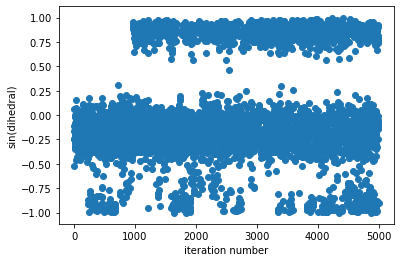

In [49]:
plt.scatter(range(n_iter), dihedrals)
plt.ylabel("sin(dihedral)")
plt.xlabel("iteration number")
plt.savefig(os.path.join(out_dir, f"{aa}_mixing.png"))
plt.show()

In [50]:
dihedrals[uncorrelated_indices].shape

(832, 1)

In [51]:
neff_max

831.31683

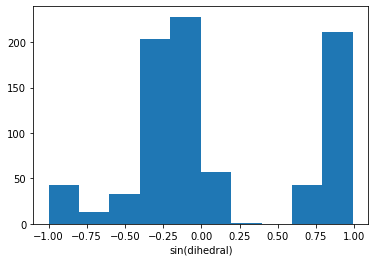

In [52]:
plt.hist(dihedrals[uncorrelated_indices])
plt.xlabel("sin(dihedral)")
plt.show()

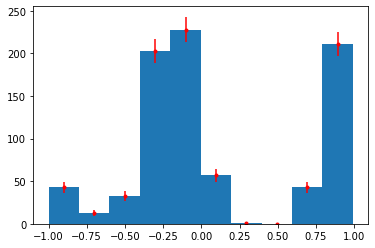

In [53]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

### old cache

In [16]:
i = 6
aa = 'thr'
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/7/{i}/"

In [17]:
old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)

In [18]:
new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)

In [19]:
old_top.n_atoms

26

In [20]:
new_top.n_atoms

22

In [21]:
# From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
from perses.analysis.utils import open_netcdf
nc = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}.nc"))
nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_checkpoint.nc"))
checkpoint_interval = nc_checkpoint.CheckpointInterval
all_positions = nc_checkpoint.variables['positions']
n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)

In [22]:
n_iter

5001

In [23]:
n_atoms

28

In [24]:
from tqdm import tqdm
index = 0 # of replica
all_pos = np.zeros(shape=(n_iter, 26, 3))
all_pos_new = np.zeros(shape=(n_iter, 22, 3))
all_pos_hybrid = np.zeros(shape=(n_iter, 28, 3))
for iteration in tqdm(range(n_iter)):
    replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
    pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
    all_pos[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system) 
    all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) 
    all_pos_new[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) 


100%|██████████| 5001/5001 [00:47<00:00, 106.36it/s]


In [12]:
np.array(all_pos).shape

(5001, 26, 3)

In [25]:
traj = md.Trajectory(np.array(all_pos), old_top)

In [26]:
traj[0].save("/data/chodera/zhangi/perses_benchmark/neq/7/24/thr_vacuum_fixed.pdb")

In [12]:
traj.save(os.path.join(out_dir, f"{aa}_traj.pdb"))

In [14]:
for atom in old_top.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
THR2-N 6
THR2-H 7
THR2-CA 8
THR2-HA 9
THR2-CB 10
THR2-C 11
THR2-O 12
THR2-HB 13
THR2-CG2 14
THR2-HG21 15
THR2-HG22 16
THR2-HG23 17
THR2-OG1 18
THR2-HG1 19
NME3-N 20
NME3-H 21
NME3-C 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [15]:
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 10, 15]])) # mdtraj atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[10, 9, 11, 16]])) # pymol atom ID
# dihedrals = md.compute_dihedrals(traj, np.array([[14, 8, 11, 12]])) # pymol atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 11, 12]])) # indices used in analyze_correlation_times
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # ALA -- from dominic (using mdtraj indices)
dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[18, 10, 8, 6]]))) # THR 


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplo

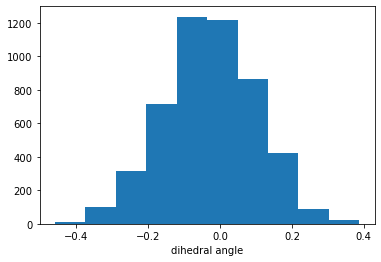

In [16]:
plt.hist(dihedrals)
plt.xlabel("dihedral angle")
plt.show()

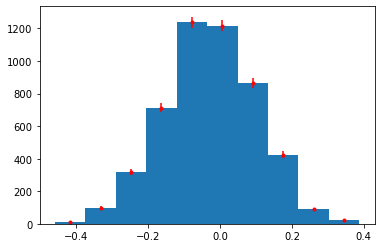

In [17]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

In [12]:
bb_dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[20, 11, 8, 6]]))) # THR 


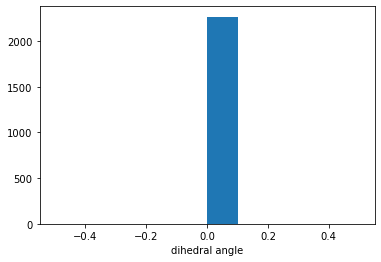

In [13]:
plt.hist(bb_dihedrals)
plt.xlabel("dihedral angle")
plt.show()

In [18]:
from perses.dispersed import feptasks
t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

In [19]:
uncorrelated_indices

[1,
 2,
 4,
 5,
 7,
 8,
 9,
 11,
 12,
 14,
 15,
 16,
 18,
 19,
 21,
 22,
 23,
 25,
 26,
 28,
 29,
 30,
 32,
 33,
 35,
 36,
 37,
 39,
 40,
 42,
 43,
 44,
 46,
 47,
 49,
 50,
 51,
 53,
 54,
 56,
 57,
 58,
 60,
 61,
 63,
 64,
 65,
 67,
 68,
 69,
 71,
 72,
 74,
 75,
 76,
 78,
 79,
 81,
 82,
 83,
 85,
 86,
 88,
 89,
 90,
 92,
 93,
 95,
 96,
 97,
 99,
 100,
 102,
 103,
 104,
 106,
 107,
 109,
 110,
 111,
 113,
 114,
 116,
 117,
 118,
 120,
 121,
 123,
 124,
 125,
 127,
 128,
 130,
 131,
 132,
 134,
 135,
 137,
 138,
 139,
 141,
 142,
 144,
 145,
 146,
 148,
 149,
 151,
 152,
 153,
 155,
 156,
 158,
 159,
 160,
 162,
 163,
 165,
 166,
 167,
 169,
 170,
 172,
 173,
 174,
 176,
 177,
 179,
 180,
 181,
 183,
 184,
 186,
 187,
 188,
 190,
 191,
 193,
 194,
 195,
 197,
 198,
 199,
 201,
 202,
 204,
 205,
 206,
 208,
 209,
 211,
 212,
 213,
 215,
 216,
 218,
 219,
 220,
 222,
 223,
 225,
 226,
 227,
 229,
 230,
 232,
 233,
 234,
 236,
 237,
 239,
 240,
 241,
 243,
 244,
 246,
 247,
 248,
 250,
 251

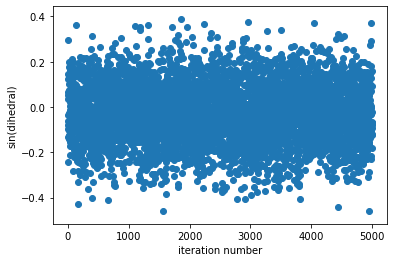

In [20]:
plt.scatter(range(n_iter), dihedrals)
plt.ylabel("sin(dihedral)")
plt.xlabel("iteration number")
plt.savefig(os.path.join(out_dir, f"{aa}_mixing.png"))
plt.show()

In [21]:
dihedrals[uncorrelated_indices].shape

(3577, 1)

In [22]:
neff_max

3577.6382

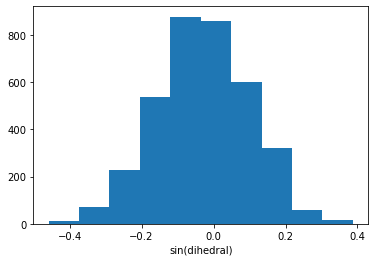

In [23]:
plt.hist(dihedrals[uncorrelated_indices])
plt.xlabel("sin(dihedral)")
plt.show()

In [25]:
snapshots = np.random.choice(uncorrelated_indices, size=200, replace=False)


In [26]:
snapshots

array([5475, 6038, 5747, 6110, 6382, 5315, 6031, 6342, 5634, 5340, 6155,
       6277, 5527, 5826, 5659, 5290, 6120, 6312, 5599, 6454, 6006, 5577,
       6220, 6404, 5318, 5709, 5941, 5687, 6043, 5308, 6474, 5841, 6173,
       5288, 5373, 6048, 6340, 6165, 5447, 6270, 5961, 5712, 6422, 5427,
       5398, 5988, 5575, 5450, 5457, 6138, 5751, 5403, 6275, 5353, 5390,
       6170, 6434, 5500, 5784, 5462, 5432, 5393, 6355, 6524, 6016, 5445,
       6512, 6158, 5602, 5672, 5682, 6013, 5948, 5363, 6479, 5587, 6292,
       5330, 6350, 5365, 5652, 5991, 5477, 6150, 5966, 6322, 6023, 5761,
       5816, 5388, 6442, 6193, 6115, 6325, 5909, 5771, 5313, 6337, 5567,
       6113, 5380, 5560, 5585, 5973, 5495, 6083, 6424, 5732, 5532, 5904,
       6330, 5485, 6387, 6190, 5355, 5310, 5505, 5692, 6332, 5811, 6100,
       5874, 5921, 5270, 5570, 6233, 5876, 5604, 5565, 6260, 6429, 5846,
       5572, 5684, 6046, 5674, 5976, 5662, 5619, 6509, 6267, 5729, 6088,
       6168, 6218, 5978, 6098, 6317, 6058, 5607, 61

In [27]:
# Save snapshot indices and positions arrays
with open(os.path.join(out_dir, f"{aa}_indices.npy"), 'wb') as f:
    np.save(f, snapshots)
with open(os.path.join(out_dir, f"{aa}_pos.npy"), 'wb') as f:
    np.save(f, all_pos)

In [28]:
all_pos[0].shape

(26, 3)

In [8]:
with open(os.path.join(out_dir, f"{'thr'}_indices.npy"), 'rb') as f:
    snapshots = np.load(f)

with open(os.path.join(out_dir, f"{aa}_pos.npy"), 'rb') as f:
    all_pos = np.load(f)

In [9]:
traj = md.Trajectory(np.array(all_pos[snapshots]), old_top)

In [10]:
traj.save("t_repex.pdb")

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplo

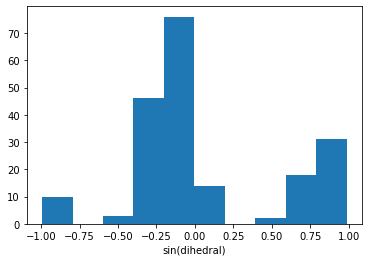

In [18]:
plt.hist(dihedrals[snapshots])
plt.xlabel("sin(dihedral)")
plt.show()

Plot dihedral distributions of new atoms

In [24]:
traj = md.Trajectory(np.array(all_pos_new), new_top)

In [76]:
traj.save(os.path.join(out_dir, f"{aa}_traj.pdb"))

In [25]:
for atom in new_top.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-C 11
ALA2-O 12
ALA2-HB1 13
ALA2-HB2 14
ALA2-HB3 15
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [26]:
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 10, 15]])) # mdtraj atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[10, 9, 11, 16]])) # pymol atom ID
# dihedrals = md.compute_dihedrals(traj, np.array([[14, 8, 11, 12]])) # pymol atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 11, 12]])) # indices used in analyze_correlation_times
dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # ALA -- from dominic (using mdtraj indices)
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[18, 10, 8, 6]]))) # THR 


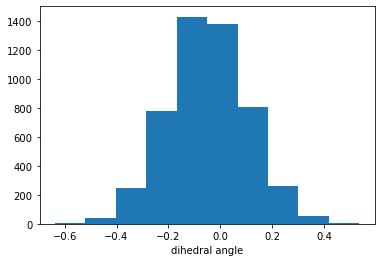

In [27]:
plt.hist(dihedrals)
plt.xlabel("dihedral angle")
plt.show()

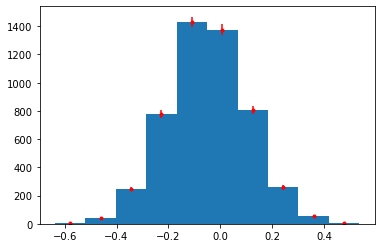

In [28]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

In [29]:
from perses.dispersed import feptasks
t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

In [30]:
uncorrelated_indices

[92,
 93,
 95,
 96,
 98,
 99,
 101,
 102,
 104,
 105,
 107,
 108,
 110,
 111,
 113,
 114,
 115,
 117,
 118,
 120,
 121,
 123,
 124,
 126,
 127,
 129,
 130,
 132,
 133,
 135,
 136,
 138,
 139,
 140,
 142,
 143,
 145,
 146,
 148,
 149,
 151,
 152,
 154,
 155,
 157,
 158,
 160,
 161,
 162,
 164,
 165,
 167,
 168,
 170,
 171,
 173,
 174,
 176,
 177,
 179,
 180,
 182,
 183,
 185,
 186,
 187,
 189,
 190,
 192,
 193,
 195,
 196,
 198,
 199,
 201,
 202,
 204,
 205,
 207,
 208,
 209,
 211,
 212,
 214,
 215,
 217,
 218,
 220,
 221,
 223,
 224,
 226,
 227,
 229,
 230,
 231,
 233,
 234,
 236,
 237,
 239,
 240,
 242,
 243,
 245,
 246,
 248,
 249,
 251,
 252,
 254,
 255,
 256,
 258,
 259,
 261,
 262,
 264,
 265,
 267,
 268,
 270,
 271,
 273,
 274,
 276,
 277,
 278,
 280,
 281,
 283,
 284,
 286,
 287,
 289,
 290,
 292,
 293,
 295,
 296,
 298,
 299,
 300,
 302,
 303,
 305,
 306,
 308,
 309,
 311,
 312,
 314,
 315,
 317,
 318,
 320,
 321,
 323,
 324,
 325,
 327,
 328,
 330,
 331,
 333,
 334,
 336,
 337

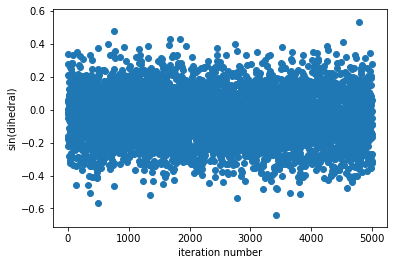

In [31]:
plt.scatter(range(n_iter), dihedrals)
plt.ylabel("sin(dihedral)")
plt.xlabel("iteration number")
plt.savefig(os.path.join(out_dir, f"{aa}_mixing.png"))
plt.show()

In [32]:
dihedrals[uncorrelated_indices].shape

(3344, 1)

In [33]:
neff_max

3344.0635

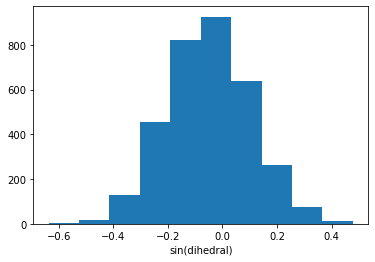

In [34]:
plt.hist(dihedrals[uncorrelated_indices])
plt.xlabel("sin(dihedral)")
plt.show()